## Overview

In this guide, we are able to evaluate several different kinds of Declarative Agents (DA) created using different technologies as experiments, and compare the results of each.

Specifically, we compare performance of AnthropicBasicRag vs OpenAIKnowledgeGPT on a test dataset of anthropic wiki pages, with eval dataset of queries and correct answers and chunks.

In [1]:
## setup
# uncomment before first use:
# !pip install anthropic
# !pip install voyageai
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install -U scikit-learn

# Common Imports
Load the common imports here to be used later

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
import importlib



# Load datasets

Loading test and evaluation datasets

In [3]:
# Load the evaluation dataset
from Helpers.voyage_vector_db import VectorDB

with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Load the Anthropic documentation
with open('data/anthropic_docs.json', 'r') as f:
    anthropic_docs = json.load(f)

# Initialize the VectorDB
db = VectorDB("anthropic_docs")
db.load_data(anthropic_docs)

Loading vector database from disk.


## Evaluating Basic RAG

In [4]:
from Experiments.basic_rag import evaluate_basic_rag_v2

start_index = 0
num_items = 20
# evaluate_basic_rag_v2(eval_data, db, start_index, num_items)

# Evaluate OpenAI GPT

Call the open GPT for eval set

StartIndex: 66, NumItems: 3


Evaluating End-to-End V2: 100%|██████████| 3/3 [00:41<00:00, 13.92s/it]


Detailed LLM responses saved to: evaluation/xmls/OpenAI_evaluation_results_detailed.xml
Detailed results saved to: evaluation/csvs/OpenAI_evaluation_results_detailed.csv
Average Precision: 0.2778
Average Recall: 0.3333
Average MRR: 0.5000
Average F1: 0.3030
End-to-End Accuracy: 0.3333
Avg Metrics saved to: evaluation/json_results/OpenAI_evaluation_results_one.json


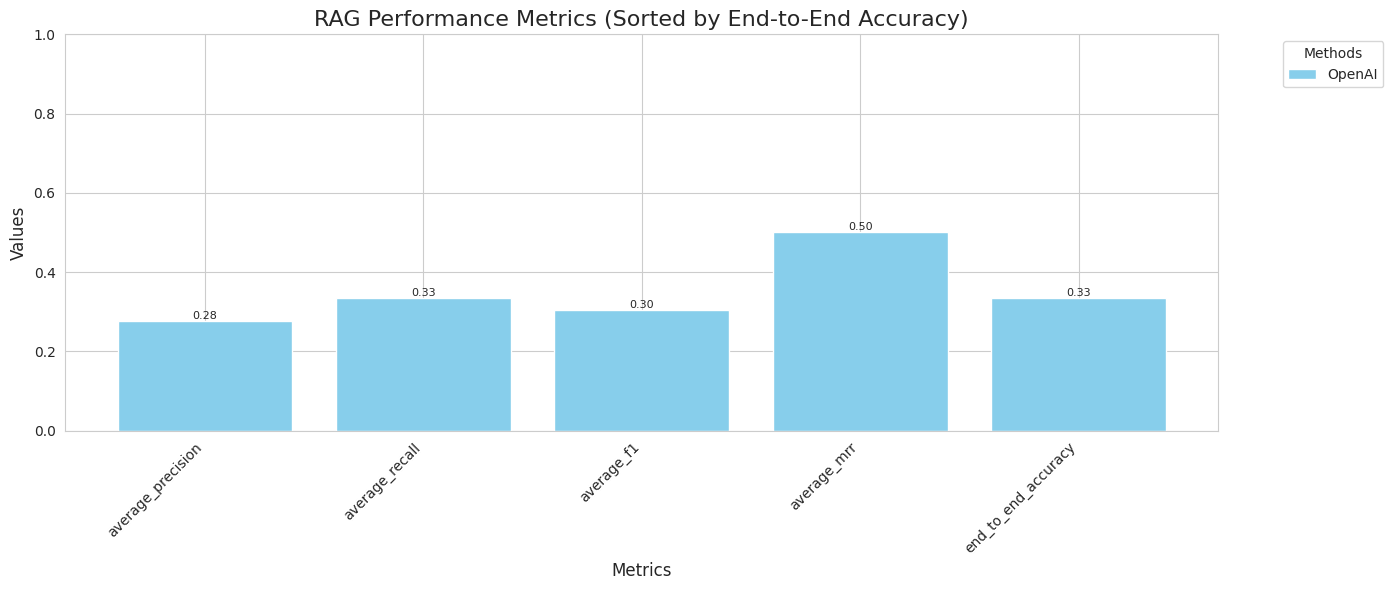

Evaluation complete: OpenAI


In [ ]:
from Experiments.openAI_gpt import evaluate_opeAI_gpt

start_index = 67
num_items = 5
evaluate_opeAI_gpt(eval_data, start_index, num_items)

# Comparisons

Compare metrics for different DAs

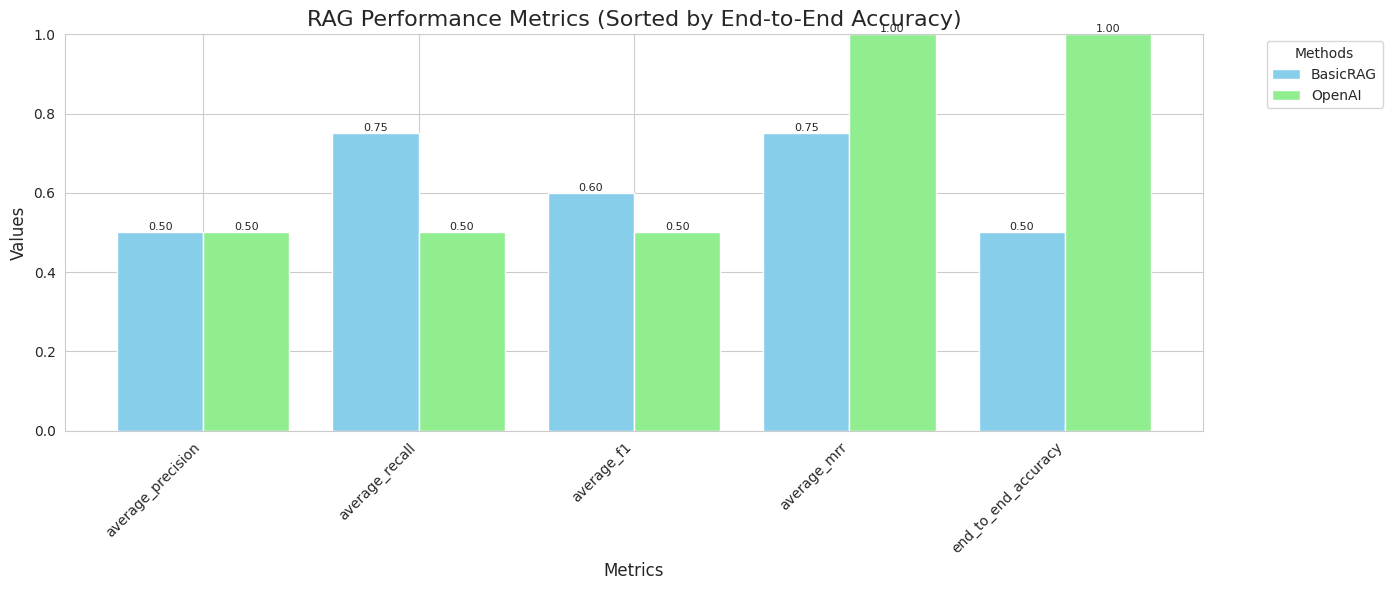

In [7]:
from Helpers.eval_helpers import plot_performance
from Experiments.basic_rag import scenario_basicRAG
from Experiments.openAI_gpt import scenario_openAI
plot_performance('evaluation/json_results', [scenario_basicRAG, scenario_openAI])